<a href="https://colab.research.google.com/github/RuchitaSuranagi/-Skin-Cancer-Classifier/blob/main/Malignant_vs_Benign_DP_Opacus_Skin_Cancer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***DP-Opacus-Skin-Cancer-Classification_AITD_Batch_22***

Benign vs Malignant

In [ ]:
#Import the necessary modules
%matplotlib inline
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

import torch
import torchcsprng as csprng
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader,Dataset,SubsetRandomSampler
import torch.nn.functional as F

import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image
import os,cv2,itertools
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)


##Importing Opacus library

In [ ]:
!git clone https://github.com/pytorch/opacus.git

Cloning into 'opacus'...
remote: Enumerating objects: 2294, done.
remote: Total 2294 (delta 0), reused 0 (delta 0), pack-reused 2294
Receiving objects: 100% (2294/2294), 1.56 MiB | 18.82 MiB/s, done.
Resolving deltas: 100% (1342/1342), done.


In [ ]:
import os
os.chdir('opacus')

In [ ]:
!pip install -e .

Obtaining file:///content/opacus
  Running setup.py develop for opacus


In [ ]:
from opacus import PrivacyEngine
from opacus.utils import module_modification

Note: The dataset was obatained from- https://www.kaggle.com/fanconic/skin-cancer-malignant-vs-benign

This skin cancer model predicates if the test image is Malignant or Benign.

In [ ]:
# authorize access to google drive

from google.colab import drive
#drive.mount("/content/drive", force_remount=True)
drive.mount('/content/drive')
!pwd

Mounted at /content/drive
/content/opacus


In [ ]:
%cd "/content/drive/My Drive/BvsM/data"

/content/drive/My Drive/BvsM/data


In [ ]:
### Directory containing data
data_dir = '/content/drive/My Drive/BvsM/data/train'

all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

In [ ]:
def compute_img_mean_std(image_paths):
#computing the mean and std of three channel on the whole dataset,
#first we should normalize the image


    img_h, img_w = 224, 224
    imgs = []
    NORM_MEAN, NORM_STD_DEV = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        NORM_MEAN.append(np.mean(pixels))
        NORM_STD_DEV.append(np.std(pixels))

    NORM_MEAN.reverse()  # BGR --> RGB
    NORM_STD_DEV.reverse()

    print("NORM_MEAN = {}".format(NORM_MEAN))
    print("NORM_STD_DEV = {}".format(NORM_STD_DEV))
    return NORM_MEAN,NORM_STD_DEV

In [ ]:
NORM_MEAN,NORM_STD_DEV = compute_img_mean_std(all_image_path)

100%|██████████| 2637/2637 [10:19<00:00,  4.26it/s]


(224, 224, 3, 2637)
NORM_MEAN = [0.76022315, 0.5367324, 0.537926]
NORM_STD_DEV = [0.1516746, 0.16006403, 0.1765569]


In [ ]:
#Hyper-parameters

MAX_GRAD_NORM = 1.2
NOISE_MULTIPLIER = .38
DELTA = 1e-5

LR = 1e-3
NUM_WORKERS = 4

BATCH_SIZE = 32
VIRTUAL_BATCH_SIZE = 64

#Define transforms
The mean and standard values of images for normalisation with data augmentations  


In [ ]:
image_transforms = {
    "train": transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),   
    transforms.ToTensor(),
    transforms.Normalize(NORM_MEAN, NORM_STD_DEV)
]),
    "test": transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(NORM_MEAN, NORM_STD_DEV)
])}

#Initialize Datasets
Creating train and testing Dataloaders.

In [ ]:
train_dataset = datasets.ImageFolder(root = data_dir,
                                      transform = image_transforms["train"]
                                     )
train_dataset

Dataset ImageFolder
    Number of datapoints: 2637
    Root location: /content/drive/My Drive/BvsM/data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.76022315, 0.5367324, 0.537926], std=[0.1516746, 0.16006403, 0.1765569])
           )

In [ ]:
#class ID's present in the dataset
train_dataset.class_to_idx

{'benign': 0, 'malignant': 1}

In [ ]:
#We will now construct a reverse of this dictionary, a mapping of ID to class.
idx2class = {v: k for k, v in train_dataset.class_to_idx.items()}

In [ ]:
#convert the dictionary to a data-frame

def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict


In [ ]:
#Create a list of indices from 0 to length of dataset.

dataset_size = len(train_dataset)
dataset_indices = list(range(dataset_size))

In [ ]:
#Shuffle the list of indices
np.random.shuffle(dataset_indices)

In [ ]:
train_idx = dataset_indices[ 0 : int(np.floor(dataset_size))]

In [ ]:
train_sampler = SubsetRandomSampler(train_idx)

In [ ]:
test_dataset = datasets.ImageFolder(root = '/content/drive/My Drive/BvsM/data/test',
                                            transform = image_transforms["test"]
                                           )
test_dataset


Dataset ImageFolder
    Number of datapoints: 660
    Root location: /content/drive/My Drive/BvsM/data/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.76022315, 0.5367324, 0.537926], std=[0.1516746, 0.16006403, 0.1765569])
           )

In [ ]:
train_loader = DataLoader(dataset=train_dataset, shuffle=False, batch_size=BATCH_SIZE, sampler=train_sampler,num_workers=NUM_WORKERS, drop_last = True)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=BATCH_SIZE)

In [ ]:
def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    if dataloader_obj.batch_size == 1:    
        for _,label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = idx2class[y_idx]
            count_dict[str(y_lbl)] += 1
    else: 
        for _,label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = idx2class[y_idx]
                count_dict[str(y_lbl)] += 1
    return count_dict

single_batch is a list of 2 elements. The first element (0th index) contains the image tensors while the second element (1st index) contains the output labels.
Here’s the first element of the list which is a tensor. This tensor is of the shape (batch, channels, height, width).

In [ ]:
single_batch = next(iter(train_loader))
single_batch[0].shape

torch.Size([32, 3, 224, 224])

In [ ]:
print("Output label tensors: ", single_batch[1])
print("\nOutput label tensor shape: ", single_batch[1].shape)

Output label tensors:  tensor([0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 1, 0, 1])

Output label tensor shape:  torch.Size([32])


In [ ]:
# Selecting the first image tensor from the batch. 
single_image = single_batch[0][0]
single_image.shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


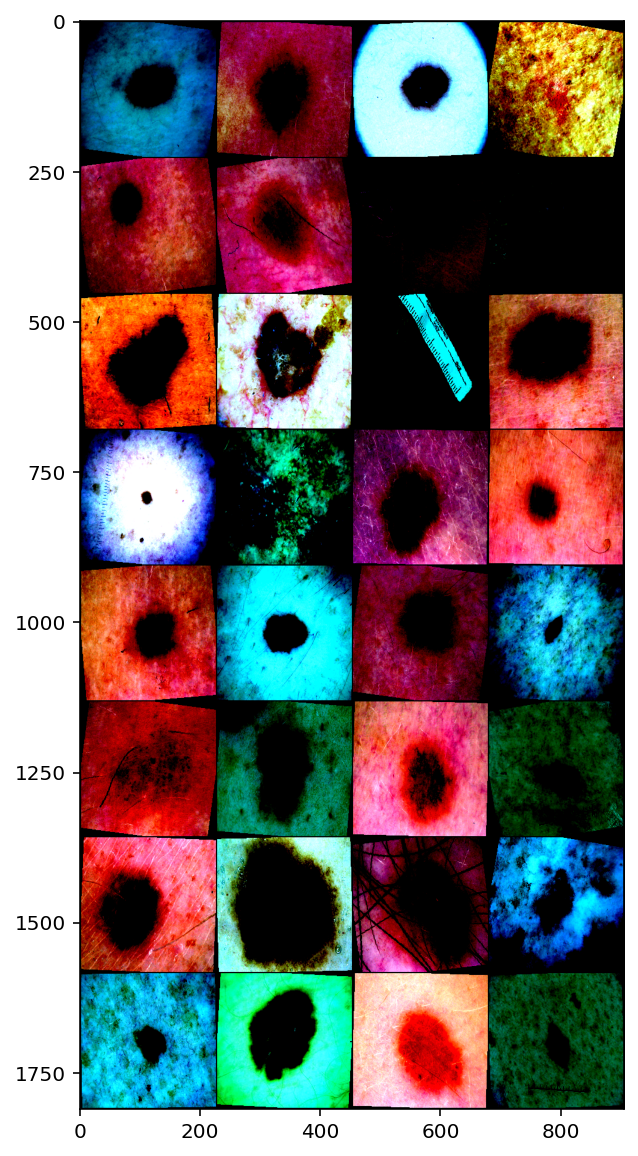

In [ ]:
from torchvision import transforms, utils, datasets
import matplotlib.pyplot as plt
 
# We do single_batch[0] because each batch is a list 
# where the 0th index is the image tensor and 1st index is the output label.
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
plt.figure(figsize = (10,10))
plt.imshow(single_batch_grid.permute(1, 2, 0))

##Training the model

In [ ]:
from torchvision import models

model = models.resnet18(num_classes=2)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from opacus.dp_model_inspector import DPModelInspector

inspector = DPModelInspector()

In [ ]:
#For model to work with Opacus we need to replace all the BatchNorm layers with GroupNorm using the convert_batchnorm_modules util function, as BatchNorm layers are not supported.

from opacus.utils import module_modification

model = module_modification.convert_batchnorm_modules(model)
inspector = DPModelInspector()
print(f"Is the model valid? {inspector.validate(model)}")

Is the model valid? True


In [ ]:
#Checking if the machine supports cuda.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
device

device(type='cuda')

In [ ]:
import torch.nn as nn
import torch.optim as optim
# using RMSprop as Opacus’ privacy engine can attach to any (first-order) optimizer.

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=LR)

In [ ]:
def accuracy(preds, labels):
    return (preds == labels).mean()

In [ ]:
from opacus import PrivacyEngine
print(f"Using sigma={NOISE_MULTIPLIER} and C={MAX_GRAD_NORM}")

privacy_engine = PrivacyEngine(
    model,
    batch_size=VIRTUAL_BATCH_SIZE,
    sample_size=len(train_dataset),
    alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
    noise_multiplier=NOISE_MULTIPLIER,
    max_grad_norm=MAX_GRAD_NORM,
)
privacy_engine.attach(optimizer)


Using sigma=0.38 and C=1.2


/content/opacus/opacus/privacy_engine.py:104: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "


In [ ]:
# VIRTUAL_BATCH_SIZE should be divisible by BATCH_SIZE

assert VIRTUAL_BATCH_SIZE % BATCH_SIZE == 0 
virtual_batch_rate = int(VIRTUAL_BATCH_SIZE / BATCH_SIZE)

In [ ]:
def train(model, train_loader, optimizer, epoch, device):
    model.train()
    criterion = nn.CrossEntropyLoss()

    losses = []
    top1_acc = []

    for i, (images, target) in enumerate(train_loader):        
        images = images.to(device)
        target = target.to(device)


        # compute output
        output = model(images)
        loss = criterion(output, target)
        
        preds = np.argmax(output.detach().cpu().numpy(), axis=1)
        labels = target.detach().cpu().numpy()
        
        # measure accuracy and record loss
        acc = accuracy(preds, labels)

        losses.append(loss.item())
        top1_acc.append(acc)
        
        loss.backward()
        	
        # take a real optimizer step after N_VIRTUAL_STEP steps t
        if ((i + 1) % virtual_batch_rate == 0) or ((i + 1) == len(train_loader)):
            optimizer.step()
            optimizer.zero_grad()
        else:
            optimizer.virtual_step() # take a virtual step

        if i % 200 == 0:
            epsilon, best_alpha = optimizer.privacy_engine.get_privacy_spent(DELTA)
            print(
                f"\tTrain Epoch: {epoch} \t"
                f"Loss: {np.mean(losses):.6f} "
                f"Acc: {np.mean(top1_acc) * 100:.6f} "
                f"(ε = {epsilon:.2f}, δ = {DELTA})"
                 )


In [ ]:
def test(model, test_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    losses = []
    top1_acc = []

    with torch.no_grad():
        for images, target in test_loader:
            images = images.to(device)
            target = target.to(device)

            output = model(images)
            loss = criterion(output, target)
            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

    top1_avg = np.mean(top1_acc)
    
    print(
        f"\tTest set:"
        f"Loss: {np.mean(losses):.6f} "
        f"Acc: {top1_avg * 100:.6f} "
    )
    return np.mean(top1_acc)


In [ ]:
from tqdm.notebook import tqdm_notebook

In [ ]:
for epoch in tqdm_notebook(range(10), desc="Epoch", unit="epoch"):
    train(model, train_loader, optimizer, epoch + 1, device)

	Train Epoch: 1 	Loss: 0.714951 Acc: 56.250000 (ε = 0.19, δ = 1e-05)
	Train Epoch: 2 	Loss: 0.598753 Acc: 75.000000 (ε = 21.95, δ = 1e-05)
	Train Epoch: 3 	Loss: 0.641340 Acc: 87.500000 (ε = 26.91, δ = 1e-05)
	Train Epoch: 4 	Loss: 0.958497 Acc: 71.875000 (ε = 30.77, δ = 1e-05)
	Train Epoch: 5 	Loss: 1.091669 Acc: 78.125000 (ε = 34.22, δ = 1e-05)
	Train Epoch: 6 	Loss: 0.624324 Acc: 87.500000 (ε = 37.02, δ = 1e-05)
	Train Epoch: 7 	Loss: 1.123145 Acc: 78.125000 (ε = 39.81, δ = 1e-05)
	Train Epoch: 8 	Loss: 0.943980 Acc: 78.125000 (ε = 42.61, δ = 1e-05)
	Train Epoch: 9 	Loss: 0.908836 Acc: 71.875000 (ε = 45.41, δ = 1e-05)
	Train Epoch: 10 	Loss: 0.642637 Acc: 81.250000 (ε = 47.58, δ = 1e-05)



In [ ]:
top1_acc = test(model, test_loader, device)

	Test set:Loss: 0.818322 Acc: 80.327381 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

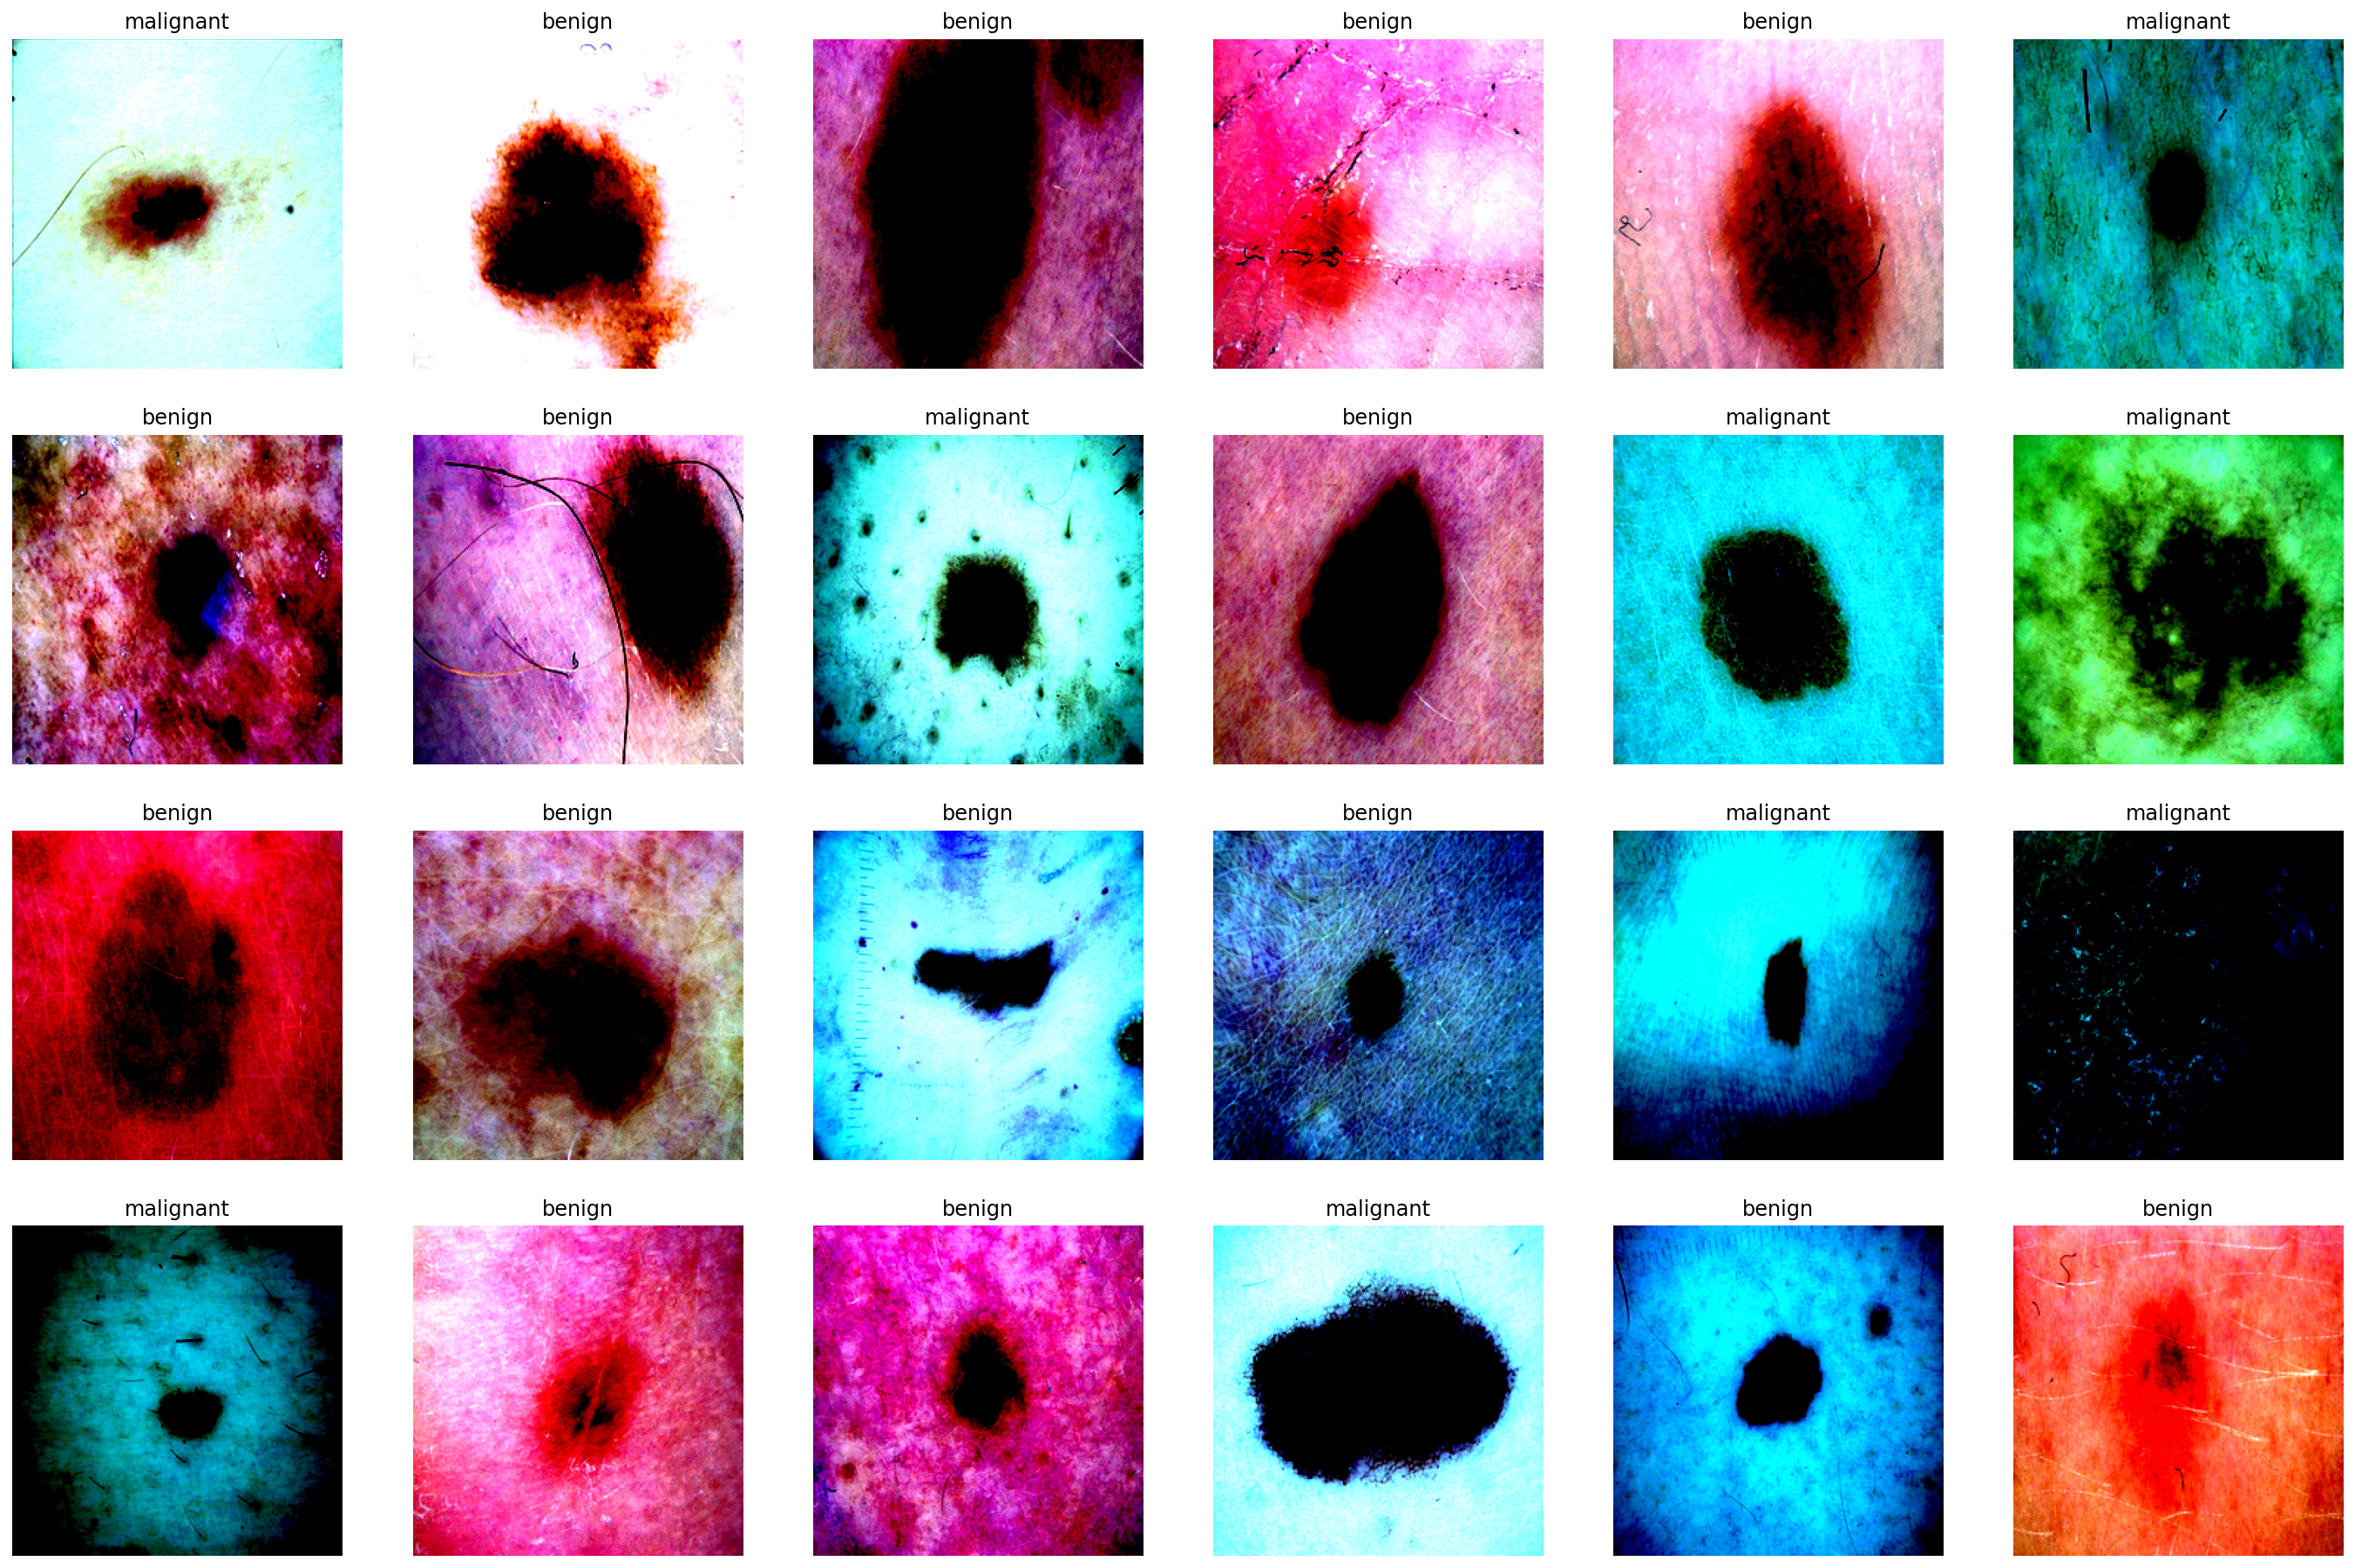

In [ ]:
samples, _ = iter(test_loader).next()
samples = samples.to(device)
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'benign', 1:'malignant'}
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))

Trained a **private ResNet18 model** for **10 epochs**.

**Test Accuracy** was found to be **80.327381** with 

**Epsilon (ε) = 47.58,Epsilon** which is proportional to the privacy budget.








We trained a non-private ResNet18 model for 10 epochs using the same hyper-parameters as above and with BatchNorm replaced with GroupNorm. The results of that was as following

Test set:Loss: 0.338749,  Acc: 85.833333 

That is, **Test Accuracy** was found to be **85.833333** 

Link for the non-private ResNet18 model : https://colab.research.google.com/drive/1HygAhbVCyloyN5z2SINGhQtpp8on3IyV?usp=sharing 